<a href="https://colab.research.google.com/github/Praxis-QR/BDSN/blob/main/ML_Pipeline_1_Customer_Conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://github.com/Praxis-QR/RDWH/raw/main/images/YantraJaalBanner.png)<br>


<hr>

[Prithwis Mukerjee](http://www.linkedin.com/in/prithwis)<br>

In [1]:
from datetime import datetime
import pytz
print('Tested',datetime.now(pytz.timezone('Asia/Calcutta')))

Tested 2023-12-13 10:37:50.325517+05:30


#Estimators, Transformers, Pipelines
[What are Pipelines & PipelineModels?](https://spark.apache.org/docs/latest/ml-pipeline.html)

![alt text](https://raw.githubusercontent.com/Praxis-QR/BDSN/main/images/pipeline.png)<br>

#Predicting Customer Conversion with Logistic Regression

#Install

In [2]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Praxis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#Load Data

In [3]:
!wget -O Data_Set.csv -q https://raw.githubusercontent.com/Praxis-QR/BDSN/main/Documents/CustomerConversion_GG.csv
# Load and Read the dataset
dfCusCon=spark.read.csv('Data_Set.csv',inferSchema=True,header=True)
# Chech the datatypes of the inputs
dfCusCon.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)



# Basic EDA :

To understand the data set and gather informations about the data

In [4]:
# Check the shape of the dataset
print((dfCusCon.count(), len(dfCusCon.columns)))

(20000, 6)


In [5]:
# Look at the dataset using SPARK
dfCusCon.show(5)

+---------+---+--------------+--------+----------------+------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+---------+---+--------------+--------+----------------+------+
|    India| 41|             1|   Yahoo|              21|     1|
|   Brazil| 28|             1|   Yahoo|               5|     0|
|   Brazil| 40|             0|  Google|               3|     0|
|Indonesia| 31|             1|    Bing|              15|     1|
| Malaysia| 32|             0|  Google|              15|     1|
+---------+---+--------------+--------+----------------+------+
only showing top 5 rows



Country and Platform are categorical and would have to be converted to numerical values

In [6]:
# Check the statistical measures of the dataset
dfCusCon.describe().show()

+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|summary| Country|              Age|   Repeat_Visitor|Platform| Web_pages_viewed|            Status|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|  count|   20000|            20000|            20000|   20000|            20000|             20000|
|   mean|    NULL|         28.53955|           0.5029|    NULL|           9.5533|               0.5|
| stddev|    NULL|7.888912950773227|0.500004090187782|    NULL|6.073903499824976|0.5000125004687693|
|    min|  Brazil|               17|                0|    Bing|                1|                 0|
|    max|Malaysia|              111|                1|   Yahoo|               29|                 1|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+



The average age of visitors is close to 28 years, and they viewed around 9 web pages during the website visit.

In [7]:
# Check individual columns using group By function to understand the data in deeply.
dfCusCon.groupBy('Country').count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



Maximum number of visitors are from Indonesia.

<Axes: xlabel='Platform', ylabel='Web_pages_viewed'>

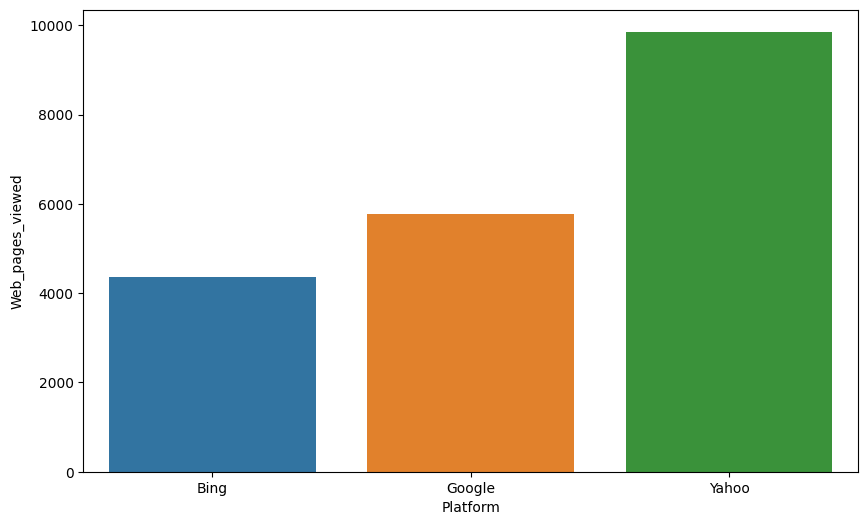

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
new_df = dfCusCon.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y = new_df.groupby('Platform').count()['Web_pages_viewed'], x = new_df.reset_index().groupby('Platform').count()['Web_pages_viewed'].index)

<Axes: xlabel='Age', ylabel='Web_pages_viewed'>

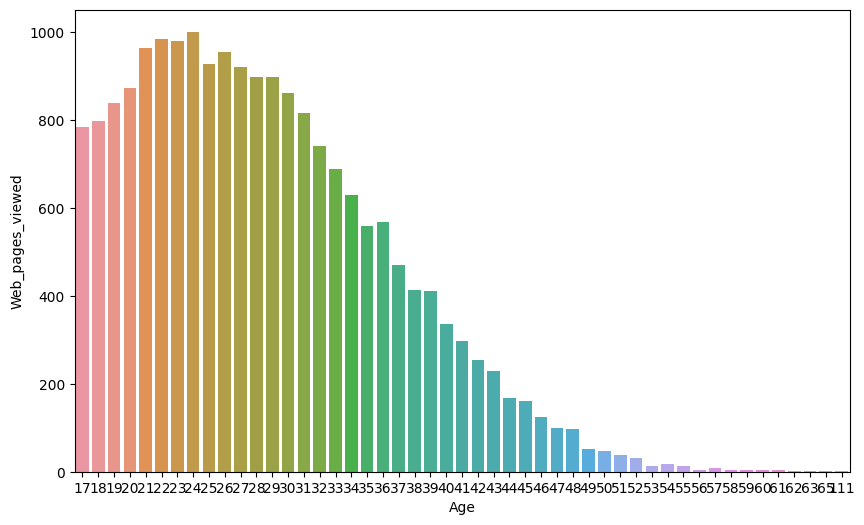

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(y = new_df.groupby('Age').count()['Web_pages_viewed'], x = new_df.reset_index().groupby('Age').count()['Web_pages_viewed'].index)

In [10]:
dfCusCon.groupBy('Platform').count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|    Bing| 4360|
|  Google| 5781|
+--------+-----+



Total numbers of Yahoo Platform users are the highest.

In [11]:
dfCusCon.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1|10000|
|     0|10000|
+------+-----+



Equal number of users who are converted and non-converted.

In [12]:
 dfCusCon.groupBy('Country').mean().show()

+---------+------------------+-------------------+---------------------+--------------------+
|  Country|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|         avg(Status)|
+---------+------------------+-------------------+---------------------+--------------------+
| Malaysia|27.792282430213465| 0.5730706075533661|   11.192118226600986|  0.6568144499178982|
|    India|27.976854156296664| 0.5433051269288203|   10.727227476356397|  0.6212045793927327|
|Indonesia| 28.43159796354081| 0.5207751683363442|    9.985711939563148|  0.5422893742814913|
|   Brazil|30.274168600154677|  0.322892498066512|    4.921113689095128|0.038669760247486466|
+---------+------------------+-------------------+---------------------+--------------------+



The average number of web_page_viewed is highest in Malaysia and lowest in Brazil.

In [13]:
dfCusCon.groupBy('Platform').mean().show()

+--------+------------------+-------------------+---------------------+------------------+
|Platform|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|       avg(Status)|
+--------+------------------+-------------------+---------------------+------------------+
|   Yahoo|28.569226087838523| 0.5094837204584644|    9.599655137437875|0.5071508266558474|
|    Bing| 28.68394495412844| 0.4720183486238532|    9.114908256880733|0.4559633027522936|
|  Google|28.380038055699707| 0.5149628092025601|    9.804878048780488|0.5210171250648676|
+--------+------------------+-------------------+---------------------+------------------+



The average number of web_page_viewed is highest for Google Platform.

In [14]:
dfCusCon.groupBy('Status').mean().show()

+------+--------+-------------------+---------------------+-----------+
|Status|avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|avg(Status)|
+------+--------+-------------------+---------------------+-----------+
|     1| 26.5435|             0.7019|              14.5617|        1.0|
|     0| 30.5356|             0.3039|               4.5449|        0.0|
+------+--------+-------------------+---------------------+-----------+



There is a strong connection between the conversion
status and the number of Web_pages_viewed along with repeat_Visitor.

# Feature Engineering :

Converting the Data for ML purposes<br>
see https://spark.apache.org/docs/latest/ml-features.html

In [15]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import LogisticRegression

##Platform Data

In [16]:
#Platform_indexer = StringIndexer(inputCol="Platform", outputCol="Platform_Num").fit(df)
Platform_indexer = StringIndexer(inputCol="Platform", outputCol="Platform_Num")
                                                                    # Estimator = Platform_indexer
                                                                    # fitted Estimator, Platform_indexer.fit(dfCusCon) is the Transformer
dfWork = Platform_indexer.fit(dfCusCon).transform(dfCusCon)
#dfWork.show(5,False)
dfWork.show(5)

+---------+---+--------------+--------+----------------+------+------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|
+---------+---+--------------+--------+----------------+------+------------+
|    India| 41|             1|   Yahoo|              21|     1|         0.0|
|   Brazil| 28|             1|   Yahoo|               5|     0|         0.0|
|   Brazil| 40|             0|  Google|               3|     0|         1.0|
|Indonesia| 31|             1|    Bing|              15|     1|         2.0|
| Malaysia| 32|             0|  Google|              15|     1|         1.0|
+---------+---+--------------+--------+----------------+------+------------+
only showing top 5 rows



In [17]:
dfWork.groupBy('Platform').count().orderBy('count', ascending=False).show(5)

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|  Google| 5781|
|    Bing| 4360|
+--------+-----+



In [18]:
dfWork.groupBy('Platform_Num').count().orderBy('count', ascending=False).show(5)

+------------+-----+
|Platform_Num|count|
+------------+-----+
|         0.0| 9859|
|         1.0| 5781|
|         2.0| 4360|
+------------+-----+



In [19]:
Platform_encoder = OneHotEncoder(inputCol="Platform_Num", outputCol="Platforms_Vector")
Platform_encoder.setDropLast(False)        #setDropLast : https://stackoverflow.com/questions/39500213/why-does-sparks-onehotencoder-drop-the-last-category-by-default
#ohe = Platform_encoder.fit(df)
                                                            # Platform_encoder, is the Estimator
                                                            # Platform_encoder.fit(dfWork), the fitted Estimator, is the Transformer
dfWork = Platform_encoder.fit(dfWork).transform(dfWork)
dfWork.show(5)

+---------+---+--------------+--------+----------------+------+------------+----------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|Platforms_Vector|
+---------+---+--------------+--------+----------------+------+------------+----------------+
|    India| 41|             1|   Yahoo|              21|     1|         0.0|   (3,[0],[1.0])|
|   Brazil| 28|             1|   Yahoo|               5|     0|         0.0|   (3,[0],[1.0])|
|   Brazil| 40|             0|  Google|               3|     0|         1.0|   (3,[1],[1.0])|
|Indonesia| 31|             1|    Bing|              15|     1|         2.0|   (3,[2],[1.0])|
| Malaysia| 32|             0|  Google|              15|     1|         1.0|   (3,[1],[1.0])|
+---------+---+--------------+--------+----------------+------+------------+----------------+
only showing top 5 rows



In [20]:
dfWork.groupBy('Platforms_Vector').count().orderBy('count', ascending=False).show(5,False)

+----------------+-----+
|Platforms_Vector|count|
+----------------+-----+
|(3,[0],[1.0])   |9859 |
|(3,[1],[1.0])   |5781 |
|(3,[2],[1.0])   |4360 |
+----------------+-----+



##Country Data

In [21]:
#Country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num").fit(df)
Country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num")
                                                                            # Country_indexer is the Estimator
                                                                            # Country_indexer.fit(dfWork), is the Transformer
dfWork = Country_indexer.fit(dfWork).transform(dfWork)
dfWork.show(5)

+---------+---+--------------+--------+----------------+------+------------+----------------+-----------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|Platforms_Vector|Country_Num|
+---------+---+--------------+--------+----------------+------+------------+----------------+-----------+
|    India| 41|             1|   Yahoo|              21|     1|         0.0|   (3,[0],[1.0])|        1.0|
|   Brazil| 28|             1|   Yahoo|               5|     0|         0.0|   (3,[0],[1.0])|        2.0|
|   Brazil| 40|             0|  Google|               3|     0|         1.0|   (3,[1],[1.0])|        2.0|
|Indonesia| 31|             1|    Bing|              15|     1|         2.0|   (3,[2],[1.0])|        0.0|
| Malaysia| 32|             0|  Google|              15|     1|         1.0|   (3,[1],[1.0])|        3.0|
+---------+---+--------------+--------+----------------+------+------------+----------------+-----------+
only showing top 5 rows



In [22]:
dfWork.groupBy('Country').count().orderBy('count', ascending = False).show(5,False)

+---------+-----+
|Country  |count|
+---------+-----+
|Indonesia|12178|
|India    |4018 |
|Brazil   |2586 |
|Malaysia |1218 |
+---------+-----+



In [23]:
dfWork.groupBy('Country_Num').count().orderBy('count', ascending = False).show(5,False)

+-----------+-----+
|Country_Num|count|
+-----------+-----+
|0.0        |12178|
|1.0        |4018 |
|2.0        |2586 |
|3.0        |1218 |
+-----------+-----+



In [24]:
Country_encoder =OneHotEncoder(inputCol="Country_Num", outputCol="Country_Vector")
Country_encoder.setDropLast(False)
                                                                           # Country_encoder is the Estimator
                                                                           # Country_encoder.fit(dfWork), is the Transformer
#ohhe = Country_encoder.fit(df)
dfWork = Country_encoder.fit(dfWork).transform(dfWork)

In [25]:
dfWork.select(['Country','Country_Num','Country_Vector']).show(5)

+---------+-----------+--------------+
|  Country|Country_Num|Country_Vector|
+---------+-----------+--------------+
|    India|        1.0| (4,[1],[1.0])|
|   Brazil|        2.0| (4,[2],[1.0])|
|   Brazil|        2.0| (4,[2],[1.0])|
|Indonesia|        0.0| (4,[0],[1.0])|
| Malaysia|        3.0| (4,[3],[1.0])|
+---------+-----------+--------------+
only showing top 5 rows



In [26]:
dfWork.groupBy('Country_Vector').count().orderBy('count', ascending = False).show(5,False)

+--------------+-----+
|Country_Vector|count|
+--------------+-----+
|(4,[0],[1.0]) |12178|
|(4,[1],[1.0]) |4018 |
|(4,[2],[1.0]) |2586 |
|(4,[3],[1.0]) |1218 |
+--------------+-----+



Categoricals have been converted into Numericals.<br>
Now to Create the Feature Vector

In [27]:
# Now it is needed to assemble all of the input columns into a single vector that would act as the input feature for the Logistic Regression model.
Feature_assembler = VectorAssembler(inputCols=['Platforms_Vector','Country_Vector','Age', 'Repeat_Visitor',
'Web_pages_viewed'], outputCol="features")
dfWork = Feature_assembler.transform(dfWork)                         # Feature Assembler is the Transformer
dfWork.show(5)

+---------+---+--------------+--------+----------------+------+------------+----------------+-----------+--------------+--------------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|Platforms_Vector|Country_Num|Country_Vector|            features|
+---------+---+--------------+--------+----------------+------+------------+----------------+-----------+--------------+--------------------+
|    India| 41|             1|   Yahoo|              21|     1|         0.0|   (3,[0],[1.0])|        1.0| (4,[1],[1.0])|(10,[0,4,7,8,9],[...|
|   Brazil| 28|             1|   Yahoo|               5|     0|         0.0|   (3,[0],[1.0])|        2.0| (4,[2],[1.0])|(10,[0,5,7,8,9],[...|
|   Brazil| 40|             0|  Google|               3|     0|         1.0|   (3,[1],[1.0])|        2.0| (4,[2],[1.0])|(10,[1,5,7,9],[1....|
|Indonesia| 31|             1|    Bing|              15|     1|         2.0|   (3,[2],[1.0])|        0.0| (4,[0],[1.0])|(10,[2,3,7,8,9],[...|
| Mala

In [28]:
dfWork[['features','Status']].show(5,False)

+----------------------------------------+------+
|features                                |Status|
+----------------------------------------+------+
|(10,[0,4,7,8,9],[1.0,1.0,41.0,1.0,21.0])|1     |
|(10,[0,5,7,8,9],[1.0,1.0,28.0,1.0,5.0]) |0     |
|(10,[1,5,7,9],[1.0,1.0,40.0,3.0])       |0     |
|(10,[2,3,7,8,9],[1.0,1.0,31.0,1.0,15.0])|1     |
|(10,[1,6,7,9],[1.0,1.0,32.0,15.0])      |1     |
+----------------------------------------+------+
only showing top 5 rows



In [29]:
dfWork.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Num: double (nullable = false)
 |-- Platforms_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)
 |-- features: vector (nullable = true)



One extra column named features, which is nothing but a combination of all the input features represented as a Single Dense Vector.

## Reducing the DataSet

In [30]:
# Now select only features column as input and the Status column as output for training the logistic regression model.
#model_df=df.select(['features','Status'])
dfWork = dfWork.select(['features','Status'])
dfWork.show(10, False)

+----------------------------------------+------+
|features                                |Status|
+----------------------------------------+------+
|(10,[0,4,7,8,9],[1.0,1.0,41.0,1.0,21.0])|1     |
|(10,[0,5,7,8,9],[1.0,1.0,28.0,1.0,5.0]) |0     |
|(10,[1,5,7,9],[1.0,1.0,40.0,3.0])       |0     |
|(10,[2,3,7,8,9],[1.0,1.0,31.0,1.0,15.0])|1     |
|(10,[1,6,7,9],[1.0,1.0,32.0,15.0])      |1     |
|(10,[1,5,7,9],[1.0,1.0,32.0,3.0])       |0     |
|(10,[1,5,7,9],[1.0,1.0,32.0,6.0])       |0     |
|(10,[1,3,7,9],[1.0,1.0,27.0,9.0])       |0     |
|(10,[0,3,7,9],[1.0,1.0,32.0,2.0])       |0     |
|(10,[2,3,7,8,9],[1.0,1.0,31.0,1.0,16.0])|1     |
+----------------------------------------+------+
only showing top 10 rows



## Splitting the Dataset :

Split the dataset into a training and test dataset in order to train and evaluate the performance of the logistic regression model. I split it in a 75/25 ratio and train our model on 75% of the dataset.

In [31]:
dfTrain, dfTest = dfWork.randomSplit([0.75,0.25])
print( dfTrain.count(), dfTest.count())

14955 5045


In [32]:
dfTrain.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 7423|
|     0| 7532|
+------+-----+



This ensures we have a balance set of the target class (Status) into the
training and test set.

In [33]:
dfTest.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 2577|
|     0| 2468|
+------+-----+



## Build and Train Logistic Regression Model:

I build and train the logistic regression model using features as the input column and status as the output column.

In [34]:
#LogReg =LogisticRegression(labelCol='Status').fit(training_df)
LogReg =LogisticRegression(labelCol='Status')

## Training Results:

We can  access the predictions made by the model using the evaluate function in SPARK that executes all the steps in an optimized way. It gives another Dataframe that contains four columns in total, including prediction and probability.

In [35]:
                                                                        # Model, LogReg is the Estimator
                                                                        # Fitted Model,LogReg.fit(dfTrain), is the Transformer
TrainResults =LogReg.fit(dfTrain).evaluate(dfTrain).predictions

In [36]:
TrainResults.count()

14955

In [37]:
TrainResults.filter(TrainResults['Status']==1).filter(TrainResults['prediction']==1).select(['Status','prediction','probability']).show(10,False)

+------+----------+----------------------------------------+
|Status|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |1.0       |[0.27044307237703197,0.7295569276229681]|
|1     |1.0       |[0.27044307237703197,0.7295569276229681]|
|1     |1.0       |[0.27044307237703197,0.7295569276229681]|
|1     |1.0       |[0.14881989565964002,0.85118010434036]  |
|1     |1.0       |[0.07618142284478825,0.9238185771552118]|
|1     |1.0       |[0.07618142284478825,0.9238185771552118]|
|1     |1.0       |[0.07618142284478825,0.9238185771552118]|
|1     |1.0       |[0.07618142284478825,0.9238185771552118]|
|1     |1.0       |[0.037438109337206,0.962561890662794]   |
|1     |1.0       |[0.037438109337206,0.962561890662794]   |
+------+----------+----------------------------------------+
only showing top 10 rows



## Evaluate Logistic Regression Model on Test Data

Now check the performance of the
model on test data. So the evaluate function is used, to make predictions on the test data.

In [38]:
#results=log_reg.evaluate(test_df).predictions
TestResults = LogReg.fit(dfTrain).evaluate(dfTest).predictions

In [39]:
TestResults.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Status: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [40]:
TestResults.select(['Status','prediction']).show(10, False)

+------+----------+
|Status|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|1     |0.0       |
|0     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|0     |1.0       |
+------+----------+
only showing top 10 rows



### Confusion Matrix:

As this is a classification problem, I use a confusion matrix to
gauge the performance of the model.

In [41]:
tp = TestResults[(TestResults.Status == 1) & (TestResults.prediction == 1)].count()
tn = TestResults[(TestResults.Status == 0) & (TestResults.prediction == 0)].count()
fp = TestResults[(TestResults.Status == 0) & (TestResults.prediction == 1)].count()
fn = TestResults[(TestResults.Status == 1) & (TestResults.prediction == 0)].count()

### Accuracy:

It is the most basic metric for evaluating any classifier.

In [42]:
accuracy=float((tp+tn) /(TestResults.count()))
print('Accuracy = ',accuracy)

Accuracy =  0.9413280475718533


### Recall:

Recall rate shows how much of the positive class cases we are able to predict correctly out of the total positive class observations.

In [43]:
recall = float(tp)/(tp + fn)
print('Recall = ',recall)

Recall =  0.9351959642995732


### Precision:

Precision rate talks about the number of true positives predicted correctly out of all the predicted positives observations.

In [44]:
precision = float(tp) / (tp + fp)
print('Precision = ',precision)

Precision =  0.9491925955100433


#Pipeline

In [45]:
from pyspark.ml import Pipeline

In [46]:
dfCusCon.show(5,False)

+---------+---+--------------+--------+----------------+------+
|Country  |Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+---------+---+--------------+--------+----------------+------+
|India    |41 |1             |Yahoo   |21              |1     |
|Brazil   |28 |1             |Yahoo   |5               |0     |
|Brazil   |40 |0             |Google  |3               |0     |
|Indonesia|31 |1             |Bing    |15              |1     |
|Malaysia |32 |0             |Google  |15              |1     |
+---------+---+--------------+--------+----------------+------+
only showing top 5 rows



In [47]:
dfTrainP, dfTestP = dfCusCon.randomSplit([0.75,0.25])
print( dfTrainP.count(), dfTestP.count())

14951 5049


In [48]:
Platform_indexer = StringIndexer(inputCol="Platform", outputCol="Platform_Num")
Platform_encoder = OneHotEncoder(inputCol="Platform_Num", outputCol="Platforms_Vector")
Platform_encoder.setDropLast(False)
Country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num")
Country_encoder = OneHotEncoder(inputCol="Country_Num", outputCol="Country_Vector")
Country_encoder.setDropLast(False)
Feature_assembler = VectorAssembler(inputCols=['Platforms_Vector','Country_Vector','Age', 'Repeat_Visitor','Web_pages_viewed'], outputCol="features")
LogReg =LogisticRegression(labelCol='Status',featuresCol='features')

In [49]:
mlPipeLine = Pipeline(stages=[Platform_indexer,Platform_encoder, Country_indexer, Country_encoder, Feature_assembler,LogReg])
# training model pipeline with data
                                                                 # mlPipeLine = Estimator
                                                                 # mlPipeLine.fit(dfTrainP), the fitted pipeline is the Transformer
mlModel = mlPipeLine.fit(dfTrainP)
TestResults = mlModel.transform(dfTestP)

In [50]:
TestResults.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Num: double (nullable = false)
 |-- Platforms_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [51]:
TestResults.select(['Status','prediction']).show(10,False)

+------+----------+
|Status|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
+------+----------+
only showing top 10 rows



## Confusion Matrix

In [52]:
tp = TestResults[(TestResults.Status == 1) & (TestResults.prediction == 1)].count()
tn = TestResults[(TestResults.Status == 0) & (TestResults.prediction == 0)].count()
fp = TestResults[(TestResults.Status == 0) & (TestResults.prediction == 1)].count()
fn = TestResults[(TestResults.Status == 1) & (TestResults.prediction == 0)].count()

## Accuracy

In [53]:
accuracy_P=float((tp+tn) /(TestResults.count()))
print('Accuracy with Pipeline = ',accuracy_P)

Accuracy with Pipeline =  0.9380075262428204


## Recall

In [54]:
recall_P = float(tp)/(tp + fn)
print('Recall with Pipeline = ',recall_P)

Recall with Pipeline =  0.936986301369863


##Precision

In [55]:
precisionP = float(tp) / (tp + fp)
print('Precision with Pipeline = ',precisionP)

Precision with Pipeline =  0.9402985074626866


#Comparison

In [56]:
print('Accuracy  :', round(accuracy_P,2), ' (with Pipeline) ', round(accuracy,2),' (without)')
print('Recall    :', round(recall_P,2), ' (with Pipeline) ', round(recall,2),' (without)')
print('Precision :', round(precisionP,2), ' (with Pipeline) ', round(precision,2),' (without)')

Accuracy  : 0.94  (with Pipeline)  0.94  (without)
Recall    : 0.94  (with Pipeline)  0.94  (without)
Precision : 0.94  (with Pipeline)  0.95  (without)


In [57]:
!date
from datetime import datetime
import pytz
print('Tested',datetime.now(pytz.timezone('Asia/Calcutta')))

Wed Dec 13 05:10:19 AM UTC 2023
Tested 2023-12-13 10:40:19.239546+05:30


#Chronobooks <br>
Two science fiction novels by Prithwis Mukerjee. A dystopian Earth. A technocratic society managed by artificial intelligence. Escape and epiphany on Mars. Can man and machine, carbon and silicon explore and escape into other dimensions of existence? An Indic perspective rooted in Advaita Vedanta and the Divine Feminine.  [More information](http://bit.ly/chronobooks) <br>
![alt text](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEg8qElM73l6qtmIS1VTUgsLLhyoGnbWGDq8g-v-g2iW1xr-IRr7FT9WW4tnKDY2sE1rJKPl7sp_p_f6ipEs-__eYU7V0SRuoLlhkopL063bEPqUTiC4lrM4toFMgaf7kpxE2m5niHwn7jZwb9ktv8OdO7OIwPL9xyyF-SiSuQE2SRemLVQRCalwDnQgdg/s16000/CTCYFooter-1.png)